In [ ]:
!pip install skforecast lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import traceback
import os
from tqdm import tqdm
from os import path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_absolute_error
import skforecast
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/all_variables1.zip", "r") as zip_file:
    # Extract all contents
    zip_file.extractall()

In [ ]:
df = pd.read_csv('/content/all_variables1/-10_10_100_120_49.csv')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')
df.head()

liquid_water_thickness  temperature  precipitation  \
2002-04-01                0.633437     0.341324       6.086234   
2002-05-01                1.064181     0.367918       4.980250   
2002-06-01               -0.905211     0.284284       5.307215   
2002-07-01               -2.874602     0.317057       3.011250   
2002-08-01               -4.843994     0.066045       3.754239   

            relative_humidity      clwc  season  month  year  quarter  \
2002-04-01          82.212124  0.000003  spring      4  2002        2   
2002-05-01          80.664751  0.000004  spring      5  2002        2   
2002-06-01          80.178718  0.000003  summer      6  2002        2   
2002-07-01          79.029472  0.000002  summer      7  2002        3   
2002-08-01          76.767973  0.000001  summer      8  2002        3   

            month_sin     month_cos   quarter_sin   quarter_cos  
2002-04-01   0.866025  5.000000e-01  1.224647e-16 -1.000000e+00  
2002-05-01   0.965926  2.588190e-01  1.224647e-16 -1.000000e+00  
2002-06-01   1.000000  6.123234e-17  1.224647e-16 -1.000000e+00  
2002-07-01   0.965926 -2.588190e-01 -1.000000e+00 -1.836970e-16  
2002-08-01   0.866025 -5.000000e-01 -1.000000e+00 -1.836970e-16

In [ ]:
climate_vars = ['liquid_water_thickness', 'temperature', 'precipitation', 'relative_humidity', 'clwc']
data = df[climate_vars]

df_data = df.copy()
exog_data = df_data.drop(climate_vars, axis=1)


In [ ]:
end_train = '2018-01-01'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}"
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}"
    f"(n={len(data_test)})"
)

Train dates : 2002-04-01 00:00:00 --- 2018-01-01 00:00:00(n=190)
Test dates  : 2018-01-01 00:00:00 --- 2028-12-01 00:00:00(n=132)


In [ ]:
exog_train = exog_data.loc[:end_train, :].copy()
exog_test  = exog_data.loc[end_train:, :].copy()

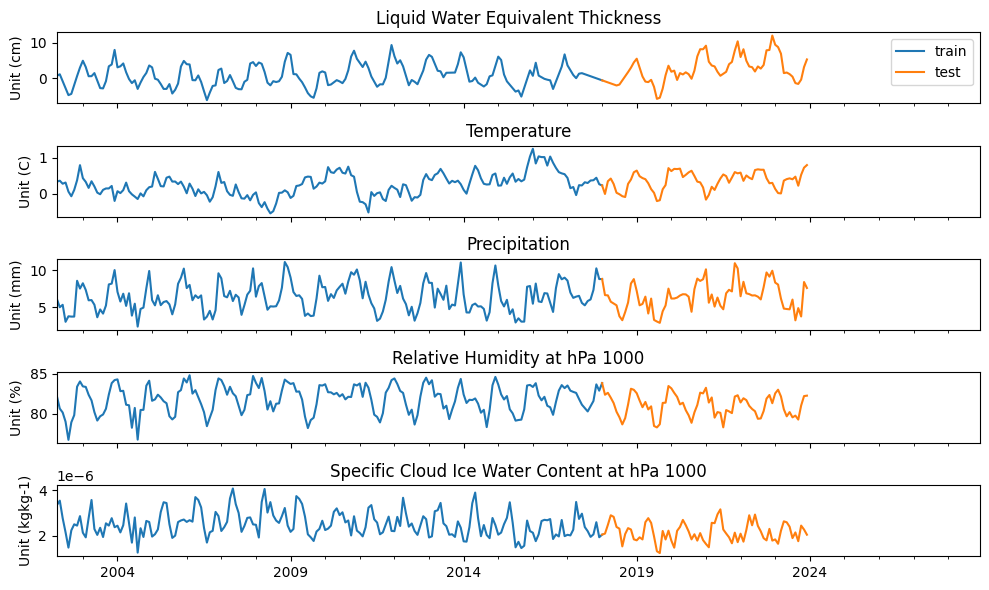

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 6), sharex=True)

data_train['liquid_water_thickness'].plot(label='train', ax=axes[0])
data_test['liquid_water_thickness'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Unit (cm)')
axes[0].set_title('Liquid Water Equivalent Thickness')
axes[0].legend()

data_train['temperature'].plot(label='train', ax=axes[1])
data_test['temperature'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('Unit (C)')
axes[1].set_title('Temperature')

data_train['precipitation'].plot(label='train', ax=axes[2])
data_test['precipitation'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('Unit (mm)')
axes[2].set_title('Precipitation')

data_train['relative_humidity'].plot(label='train', ax=axes[3])
data_test['relative_humidity'].plot(label='test', ax=axes[3])
axes[3].set_xlabel('')
axes[3].set_ylabel('Unit (%)')
axes[3].set_title('Relative Humidity at hPa 1000')

data_train['clwc'].plot(label='train', ax=axes[4])
data_test['clwc'].plot(label='test', ax=axes[4])
axes[4].set_xlabel('')
axes[4].set_ylabel('Unit (kgkg-1)')
axes[4].set_title('Specific Cloud Ice Water Content at hPa 1000')

fig.tight_layout()
plt.show();

## Process All the Grids

In [ ]:
# one-hot encoding
categorical_features = ["season"]
transformer_exog = make_column_transformer(
    (
        OrdinalEncoder(
            dtype=int,
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            encoded_missing_value=-1
        ),
        categorical_features
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")


def search_space(trial):

  # Lags grid
  lags_grid = tuple([12, 24, [1, 2, 3, 4, 7, 9, 24]])

  search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
  return search_space


In [ ]:
def search_hyperparameters(data, end_train, end_valid, series_vars, exog_features,transformer_exog):

  # Bayesian search hyperparameters and lags with Optuna
  forecaster = ForecasterAutoregMultiVariate(
                    regressor = LGBMRegressor(random_state=15926, verbose=-1),
                    lags = 24,
                    steps = 24,
                    level = 'liquid_water_thickness',
                    transformer_series = StandardScaler(),
                    transformer_exog = transformer_exog,
                    fit_kwargs       = {"categorical_feature": "auto"},
                    weight_func        = None,
                    n_jobs             = 'auto'
              )

  results, _ = bayesian_search_forecaster_multiseries(
                          forecaster            = forecaster,
                          series                = data.loc[:end_valid, series_vars],
                          exog                  = data.loc[:end_valid, exog_features],
                          search_space          = search_space,
                          steps                 = 24,
                          metric                = 'mean_absolute_percentage_error',
                          aggregate_metric      = 'weighted_average',
                          refit                 = False,
                          initial_train_size    = len(data.loc[:end_train]),
                          fixed_train_size      = False,
                          n_trials              = 5,
                          random_state          = 123,
                          return_best           = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {}
                      )
  best_params = results['params'].iat[0]

  return best_params


In [ ]:
def train_and_predict(data, best_params, end_valid, end_train, valid_num, train_num, df_idx, series_vars, exog_features, transformer_exog):

  # train for evaluation of the model
  forecaster = ForecasterAutoregMultiVariate(
                  regressor = LGBMRegressor(**best_params, random_state=15926, verbose=-1),
                  lags = 24,
                  steps = 60,
                  level = 'liquid_water_thickness',
                  transformer_series = StandardScaler(),
                  transformer_exog = transformer_exog,
                  fit_kwargs       = {"categorical_feature": "auto"},
                  weight_func        = None,
                  n_jobs             = 'auto'
             )

  forecaster.fit(
      series=data.loc[:end_valid, series_vars],
      exog=data.loc[:end_valid, exog_features])

  # Predict for 5 years into the future
  predictions = forecaster.predict(
    exog     = data.loc[df_idx[valid_num+1]:, exog_features]
  )
  df_preds = pd.DataFrame(predictions)

  importance = forecaster.get_feature_importances(step=60)

  return df_preds, importance[:10]


In [ ]:
def populate_test_data(data_dir):

  preds_dict = {}
  important_features = []

  # collect all files in the directory
  filenames = os.listdir(data_dir)

  try:

    for filename in tqdm(filenames):

        grid = filename.split(".")[0].split("-")[-1]
        filepath = path.join(data_dir, filename)
        df = pd.read_csv(filepath)
        df["season"] = df["season"].astype("category")
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        df.index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')

        # get the estimate end train and end validation dates
        data = df.copy()
        series = climate_vars
        exog_data = data.drop(series, axis=1)
        exog_features = exog_data.columns
        df_idx = data.index
        train_num = int(len(data.loc[: df_idx[-62]]) * 0.8)
        valid_num = len(data.loc[: df_idx[-62]])
        end_train = df_idx[train_num]
        end_valid = df_idx[valid_num]
        end_evaluation = df_idx[train_num+24]
        evaluate_data = data.loc[df_idx[train_num+1]: end_evaluation, 'liquid_water_thickness'].values


        # tune for best hyperparamters and evaluate on MAPE metric
        best_params = search_hyperparameters(data, end_train, end_valid, series, exog_features, transformer_exog)

        # train and make predict for 5 years
        df_predictions, important = train_and_predict(data,best_params, end_valid, end_train, valid_num, train_num, df_idx, series, exog_features, transformer_exog)
        df_predictions["pred"] =  df_predictions["liquid_water_thickness"].round(2)
        preds_dict[grid] = df_predictions['pred'].values
        important_features.append(important)

  except Exception as ex:
    print("[Error]")
    print(traceback.format_exc())

  df_final_preds = pd.DataFrame(preds_dict, index=range(60))
  df_final_preds.index = pd.date_range(start=pd.Timestamp("2023-12-01") + pd.DateOffset(months=1), periods=60, freq='MS')

  print("> Done")

  return df_final_preds, important_features


### Features Importance at step 1 (2024-01-01)

In [ ]:
data_dir = "/content/all_variables1"

df_submission, important_features = populate_test_data(data_dir)

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  1%|          | 1/162 [00:22<1:01:26, 22.90s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  1%|          | 2/162 [00:43<57:01, 21.38s/it]  

  0%|          | 0/5 [00:00<?, ?it/s]

  2%|▏         | 3/162 [01:04<57:00, 21.51s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  2%|▏         | 4/162 [01:28<58:53, 22.37s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  3%|▎         | 5/162 [01:51<58:44, 22.45s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  4%|▎         | 6/162 [02:12<57:34, 22.14s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  4%|▍         | 7/162 [02:18<43:01, 16.66s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  5%|▍         | 8/162 [02:42<48:58, 19.08s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  6%|▌         | 9/162 [03:04<51:24, 20.16s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  6%|▌         | 10/162 [03:27<53:04, 20.95s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  7%|▋         | 11/162 [03:50<53:57, 21.44s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  7%|▋         | 12/162 [03:56<41:52, 16.75s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  8%|▊         | 13/162 [04:17<45:04, 18.15s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  9%|▊         | 14/162 [04:40<48:43, 19.75s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  9%|▉         | 15/162 [04:46<37:52, 15.46s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 10%|▉         | 16/162 [04:53<31:34, 12.98s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 10%|█         | 17/162 [05:15<37:52, 15.67s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 11%|█         | 18/162 [05:38<43:02, 17.93s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 12%|█▏        | 19/162 [05:44<33:45, 14.17s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 12%|█▏        | 20/162 [06:06<39:34, 16.72s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 13%|█▎        | 21/162 [06:12<31:18, 13.32s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 14%|█▎        | 22/162 [06:34<37:20, 16.00s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 14%|█▍        | 23/162 [06:39<29:41, 12.81s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 15%|█▍        | 24/162 [06:45<24:46, 10.77s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 15%|█▌        | 25/162 [07:08<32:54, 14.41s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 16%|█▌        | 26/162 [07:28<36:32, 16.12s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 17%|█▋        | 27/162 [07:51<40:18, 17.91s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 17%|█▋        | 28/162 [07:56<31:35, 14.14s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 18%|█▊        | 29/162 [08:20<37:39, 16.99s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 19%|█▊        | 30/162 [08:25<29:43, 13.51s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 19%|█▉        | 31/162 [08:46<34:09, 15.64s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|█▉        | 32/162 [09:09<38:41, 17.86s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 33/162 [09:15<30:46, 14.32s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 21%|██        | 34/162 [09:38<36:17, 17.01s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 22%|██▏       | 35/162 [10:02<40:31, 19.15s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 22%|██▏       | 36/162 [10:24<42:03, 20.03s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 23%|██▎       | 37/162 [10:48<43:55, 21.09s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 23%|██▎       | 38/162 [11:09<43:27, 21.03s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 24%|██▍       | 39/162 [11:15<34:21, 16.76s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 25%|██▍       | 40/162 [11:37<37:10, 18.28s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 25%|██▌       | 41/162 [11:43<29:31, 14.64s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 26%|██▌       | 42/162 [11:50<24:21, 12.18s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 27%|██▋       | 43/162 [12:12<30:01, 15.14s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 27%|██▋       | 44/162 [12:35<34:47, 17.69s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 28%|██▊       | 45/162 [12:56<36:16, 18.60s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 28%|██▊       | 46/162 [13:20<38:56, 20.15s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 29%|██▉       | 47/162 [13:26<30:17, 15.81s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 30%|██▉       | 48/162 [13:49<34:32, 18.18s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 30%|███       | 49/162 [13:55<27:01, 14.35s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 31%|███       | 50/162 [14:02<22:40, 12.15s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 31%|███▏      | 51/162 [14:07<18:47, 10.16s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 32%|███▏      | 52/162 [14:31<25:51, 14.10s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 33%|███▎      | 53/162 [14:52<29:47, 16.40s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 33%|███▎      | 54/162 [14:59<24:26, 13.58s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 34%|███▍      | 55/162 [15:21<28:25, 15.94s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 35%|███▍      | 56/162 [15:44<31:51, 18.04s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 35%|███▌      | 57/162 [15:49<24:55, 14.24s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 36%|███▌      | 58/162 [15:56<20:56, 12.08s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 36%|███▋      | 59/162 [16:18<25:52, 15.07s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 37%|███▋      | 60/162 [16:25<21:18, 12.54s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 38%|███▊      | 61/162 [16:31<17:40, 10.50s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 38%|███▊      | 62/162 [16:54<23:50, 14.30s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 39%|███▉      | 63/162 [17:16<27:26, 16.63s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|███▉      | 64/162 [17:40<30:45, 18.84s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 65/162 [17:45<24:00, 14.85s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 41%|████      | 66/162 [18:09<27:48, 17.38s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 41%|████▏     | 67/162 [18:14<21:48, 13.77s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 42%|████▏     | 68/162 [18:37<25:53, 16.53s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 43%|████▎     | 69/162 [18:43<20:41, 13.35s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 43%|████▎     | 70/162 [18:48<16:49, 10.97s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 44%|████▍     | 71/162 [18:55<14:54,  9.83s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 44%|████▍     | 72/162 [19:01<12:44,  8.49s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 45%|████▌     | 73/162 [19:24<19:21, 13.05s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 46%|████▌     | 74/162 [19:46<22:58, 15.67s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 46%|████▋     | 75/162 [20:10<26:04, 17.99s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 47%|████▋     | 76/162 [20:30<26:54, 18.77s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 48%|████▊     | 77/162 [20:54<28:48, 20.34s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 48%|████▊     | 78/162 [21:16<29:09, 20.83s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 49%|████▉     | 79/162 [21:40<30:01, 21.70s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 49%|████▉     | 80/162 [22:02<29:55, 21.90s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 50%|█████     | 81/162 [22:09<23:22, 17.32s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 51%|█████     | 82/162 [22:14<18:21, 13.77s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 51%|█████     | 83/162 [22:22<15:31, 11.79s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 52%|█████▏    | 84/162 [22:27<12:50,  9.88s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 52%|█████▏    | 85/162 [22:49<17:19, 13.50s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 53%|█████▎    | 86/162 [22:55<14:09, 11.17s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 54%|█████▎    | 87/162 [23:00<11:52,  9.50s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 54%|█████▍    | 88/162 [23:23<16:36, 13.47s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 55%|█████▍    | 89/162 [23:46<19:57, 16.40s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 56%|█████▌    | 90/162 [23:53<16:07, 13.44s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 56%|█████▌    | 91/162 [23:58<13:03, 11.03s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 57%|█████▋    | 92/162 [24:22<17:17, 14.83s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 57%|█████▋    | 93/162 [24:27<13:48, 12.01s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 58%|█████▊    | 94/162 [24:51<17:36, 15.54s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 59%|█████▊    | 95/162 [24:57<13:58, 12.52s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 59%|█████▉    | 96/162 [25:20<17:27, 15.87s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|█████▉    | 97/162 [25:42<19:11, 17.71s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 98/162 [25:50<15:32, 14.57s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 61%|██████    | 99/162 [26:11<17:37, 16.78s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 62%|██████▏   | 100/162 [26:36<19:37, 18.99s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 62%|██████▏   | 101/162 [26:58<20:14, 19.91s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 63%|██████▎   | 102/162 [27:05<16:03, 16.06s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 64%|██████▎   | 103/162 [27:26<17:24, 17.70s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 64%|██████▍   | 104/162 [27:34<14:05, 14.57s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 65%|██████▍   | 105/162 [27:39<11:13, 11.82s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 65%|██████▌   | 106/162 [28:03<14:20, 15.36s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 66%|██████▌   | 107/162 [28:25<15:55, 17.38s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 67%|██████▋   | 108/162 [28:49<17:23, 19.32s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 67%|██████▋   | 109/162 [28:54<13:24, 15.18s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 68%|██████▊   | 110/162 [29:01<11:01, 12.71s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 69%|██████▊   | 111/162 [29:23<13:14, 15.57s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 69%|██████▉   | 112/162 [29:30<10:45, 12.90s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 70%|██████▉   | 113/162 [29:36<08:48, 10.78s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 70%|███████   | 114/162 [29:41<07:22,  9.23s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 71%|███████   | 115/162 [30:05<10:40, 13.62s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 72%|███████▏  | 116/162 [30:28<12:35, 16.42s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 72%|███████▏  | 117/162 [30:51<13:50, 18.47s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 73%|███████▎  | 118/162 [31:14<14:25, 19.66s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 73%|███████▎  | 119/162 [31:20<11:10, 15.60s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 74%|███████▍  | 120/162 [31:40<11:44, 16.78s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 75%|███████▍  | 121/162 [32:04<12:57, 18.97s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 75%|███████▌  | 122/162 [32:09<09:56, 14.92s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 76%|███████▌  | 123/162 [32:33<11:26, 17.60s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 77%|███████▋  | 124/162 [32:54<11:53, 18.77s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 77%|███████▋  | 125/162 [33:18<12:24, 20.11s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 78%|███████▊  | 126/162 [33:23<09:25, 15.72s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 78%|███████▊  | 127/162 [33:31<07:42, 13.22s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 79%|███████▉  | 128/162 [33:36<06:10, 10.89s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|███████▉  | 129/162 [34:00<08:09, 14.85s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 130/162 [34:22<09:05, 17.05s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 81%|████████  | 131/162 [34:29<07:16, 14.08s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 81%|████████▏ | 132/162 [34:51<08:13, 16.44s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 82%|████████▏ | 133/162 [34:58<06:35, 13.62s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 83%|████████▎ | 134/162 [35:19<07:23, 15.84s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 83%|████████▎ | 135/162 [35:25<05:48, 12.91s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 84%|████████▍ | 136/162 [35:32<04:46, 11.01s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 85%|████████▍ | 137/162 [35:55<06:01, 14.45s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 85%|████████▌ | 138/162 [36:01<04:52, 12.20s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 86%|████████▌ | 139/162 [36:07<03:54, 10.17s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 86%|████████▋ | 140/162 [36:31<05:12, 14.22s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 87%|████████▋ | 141/162 [36:53<05:50, 16.67s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 88%|████████▊ | 142/162 [37:17<06:15, 18.80s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 88%|████████▊ | 143/162 [37:40<06:23, 20.17s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 89%|████████▉ | 144/162 [38:03<06:17, 20.95s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 90%|████████▉ | 145/162 [38:27<06:11, 21.88s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 90%|█████████ | 146/162 [38:33<04:32, 17.03s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 91%|█████████ | 147/162 [38:55<04:40, 18.68s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 91%|█████████▏| 148/162 [39:18<04:39, 19.94s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 92%|█████████▏| 149/162 [39:42<04:34, 21.08s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 93%|█████████▎| 150/162 [39:47<03:16, 16.40s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 93%|█████████▎| 151/162 [39:53<02:26, 13.29s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 94%|█████████▍| 152/162 [40:17<02:43, 16.32s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 94%|█████████▍| 153/162 [40:39<02:43, 18.20s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 95%|█████████▌| 154/162 [40:46<01:56, 14.62s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 96%|█████████▌| 155/162 [40:51<01:23, 11.89s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 96%|█████████▋| 156/162 [40:58<01:02, 10.45s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 97%|█████████▋| 157/162 [41:19<01:08, 13.71s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 98%|█████████▊| 158/162 [41:43<01:06, 16.73s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 98%|█████████▊| 159/162 [42:05<00:55, 18.35s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 99%|█████████▉| 160/162 [42:30<00:40, 20.11s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 99%|█████████▉| 161/162 [42:53<00:20, 20.96s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 162/162 [42:59<00:00, 15.92s/it]

> Done


In [ ]:
df_submission

50_70_240_260_115  10_10_180_200_85  70_90_340_360_161  \
2024-01-01              -3.32              3.96              -5.48   
2024-02-01              -2.24              3.92              -5.39   
2024-03-01               0.12              3.20              -4.71   
2024-04-01               0.21              3.29              -3.29   
2024-05-01               0.27              3.38              -2.76   
2024-06-01              -1.33              4.30              -2.28   
2024-07-01              -2.24              4.11              -4.29   
2024-08-01              -2.79              4.75              -5.03   
2024-09-01              -2.39              3.53              -5.98   
2024-10-01              -2.57              3.14              -4.28   
2024-11-01              -1.21              3.48              -4.63   
2024-12-01              -0.24              3.48              -4.06   
2025-01-01               0.52              3.47              -6.25   
2025-02-01               2.03              2.84              -4.27   
2025-03-01               3.46              2.17              -3.32   
2025-04-01               3.21              2.31              -4.48   
2025-05-01               1.58              2.41              -4.71   
2025-06-01               0.12              3.21              -6.90   
2025-07-01              -2.97              3.73              -7.02   
2025-08-01              -4.23              3.35              -7.39   
2025-09-01              -5.57              3.68              -6.23   
2025-10-01              -3.83              3.03              -6.35   
2025-11-01              -1.81              3.12              -7.78   
2025-12-01              -3.04              2.80              -7.98   
2026-01-01              -2.46              2.94              -9.02   
2026-02-01              -2.61              2.31              -7.16   
2026-03-01              -2.45              3.44              -9.48   
2026-04-01              -3.78              3.41             -10.88   
2026-05-01              -4.77              3.79              -7.99   
2026-06-01              -5.78              4.51              -8.87   
2026-07-01              -6.73              5.48              -7.33   
2026-08-01              -8.38              5.23              -9.52   
2026-09-01              -9.11              5.19              -8.31   
2026-10-01              -8.58              4.46              -8.46   
2026-11-01              -8.81              4.64              -9.46   
2026-12-01              -6.89              5.30              -8.33   
2027-01-01              -3.26              4.22              -7.67   
2027-02-01              -2.23              4.08              -9.17   
2027-03-01              -1.96              4.19             -10.71   
2027-04-01              -2.06              4.93              -6.60   
2027-05-01              -2.40              5.31              -6.86   
2027-06-01              -3.13              4.42              -8.03   
2027-07-01              -4.53              4.97              -8.17   
2027-08-01              -5.60              4.88              -7.60   
2027-09-01              -4.09              4.94              -8.09   
2027-10-01              -5.29              4.96              -7.56   
2027-11-01              -3.76              4.68              -7.72   
2027-12-01              -0.50              4.45              -6.62   
2028-01-01              -1.15              3.52             -10.84   
2028-02-01               1.01              3.89             -11.20   
2028-03-01               2.08              3.25              -7.95   
2028-04-01               1.32              2.86              -7.88   
2028-05-01               2.24              2.64              -8.04   
2028-06-01              -1.97              3.85              -9.28   
2028-07-01              -3.29              5.05              -8.33   
2028-08-01              -2.40              5.12              -8.18   
2028-09-01            

In [ ]:
features = pd.concat(important_features)
features

feature  importance
58          precipitation_lag_11          59
0   liquid_water_thickness_lag_1          47
90      relative_humidity_lag_19          46
34            temperature_lag_11          39
74       relative_humidity_lag_3          34
..                           ...         ...
91      relative_humidity_lag_20           0
90      relative_humidity_lag_19           0
89      relative_humidity_lag_18           0
88      relative_humidity_lag_17           0
87      relative_humidity_lag_16           0

[1620 rows x 2 columns]

In [ ]:
feat = features.groupby("feature")["importance"].sum().sort_values(ascending=False)[:30]
feat

feature
liquid_water_thickness_lag_1     1144
temperature_lag_6                 636
liquid_water_thickness_lag_12     556
temperature_lag_8                 534
clwc_lag_9                        533
temperature_lag_7                 493
precipitation_lag_5               491
temperature_lag_14                480
temperature_lag_20                465
relative_humidity_lag_2           463
precipitation_lag_15              461
liquid_water_thickness_lag_7      459
liquid_water_thickness_lag_21     458
temperature_lag_17                457
temperature_lag_16                440
clwc_lag_5                        436
relative_humidity_lag_12          428
temperature_lag_2                 423
relative_humidity_lag_14          422
liquid_water_thickness_lag_24     420
precipitation_lag_9               411
relative_humidity_lag_24          408
liquid_water_thickness_lag_9      407
relative_humidity_lag_5           403
clwc_lag_10                       380
precipitation_lag_1               380
clwc_lag_8                        379
precipitation_lag_3               372
temperature_lag_5                 370
clwc_lag_16                       370
Name: importance, dtype: int32

### Features Importance at step 60 (2028-12-01)

In [ ]:
data_dir = "/content/all_variables1"

df_submission, important_features = populate_test_data(data_dir)

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  1%|          | 1/162 [00:05<15:21,  5.72s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  1%|          | 2/162 [00:12<16:36,  6.23s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  2%|▏         | 3/162 [00:40<42:47, 16.15s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  2%|▏         | 4/162 [01:09<55:40, 21.14s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  3%|▎         | 5/162 [01:16<42:15, 16.15s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  4%|▎         | 6/162 [01:38<46:59, 18.08s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  4%|▍         | 7/162 [02:01<50:56, 19.72s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  5%|▍         | 8/162 [02:23<52:50, 20.59s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  6%|▌         | 9/162 [02:46<54:17, 21.29s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  6%|▌         | 10/162 [02:52<41:42, 16.46s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  7%|▋         | 11/162 [03:16<47:12, 18.76s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  7%|▋         | 12/162 [03:21<36:55, 14.77s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  8%|▊         | 13/162 [03:46<43:50, 17.65s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  9%|▊         | 14/162 [04:09<47:31, 19.27s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  9%|▉         | 15/162 [04:32<50:25, 20.58s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 10%|▉         | 16/162 [04:39<39:56, 16.42s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 10%|█         | 17/162 [04:47<33:45, 13.97s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 11%|█         | 18/162 [04:53<27:35, 11.50s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 12%|█▏        | 19/162 [05:17<36:06, 15.15s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 12%|█▏        | 20/162 [05:40<41:36, 17.58s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 13%|█▎        | 21/162 [06:02<44:41, 19.02s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 14%|█▎        | 22/162 [06:27<48:03, 20.60s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 14%|█▍        | 23/162 [06:32<37:20, 16.12s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 15%|█▍        | 24/162 [06:56<42:08, 18.32s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 15%|█▌        | 25/162 [07:02<33:15, 14.57s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 16%|█▌        | 26/162 [07:26<39:29, 17.42s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 17%|█▋        | 27/162 [07:48<42:32, 18.90s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 17%|█▋        | 28/162 [07:55<34:28, 15.44s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 18%|█▊        | 29/162 [08:17<38:36, 17.42s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 19%|█▊        | 30/162 [08:25<31:45, 14.43s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 19%|█▉        | 31/162 [08:49<37:44, 17.29s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|█▉        | 32/162 [09:12<41:36, 19.20s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 33/162 [09:18<32:33, 15.15s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 21%|██        | 34/162 [09:25<27:15, 12.78s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 22%|██▏       | 35/162 [09:47<32:43, 15.46s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 22%|██▏       | 36/162 [09:55<27:25, 13.06s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 23%|██▎       | 37/162 [10:00<22:41, 10.89s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 23%|██▎       | 38/162 [10:08<20:20,  9.84s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 24%|██▍       | 39/162 [10:30<27:48, 13.56s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 25%|██▍       | 40/162 [10:53<33:34, 16.51s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 25%|██▌       | 41/162 [10:59<26:44, 13.26s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 26%|██▌       | 42/162 [11:06<22:58, 11.49s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 27%|██▋       | 43/162 [11:12<19:24,  9.78s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 27%|██▋       | 44/162 [11:35<26:52, 13.66s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 28%|██▊       | 45/162 [11:41<22:00, 11.29s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 28%|██▊       | 46/162 [11:48<19:16,  9.97s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 29%|██▉       | 47/162 [12:09<25:25, 13.27s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 30%|██▉       | 48/162 [12:37<33:41, 17.73s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 30%|███       | 49/162 [12:59<35:56, 19.08s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 31%|███       | 50/162 [13:06<29:02, 15.56s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 31%|███▏      | 51/162 [13:28<32:03, 17.33s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 32%|███▏      | 52/162 [13:51<35:01, 19.10s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 33%|███▎      | 53/162 [14:13<36:21, 20.02s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 33%|███▎      | 54/162 [14:37<38:13, 21.23s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 34%|███▍      | 55/162 [14:43<29:36, 16.60s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 35%|███▍      | 56/162 [14:50<24:28, 13.85s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 35%|███▌      | 57/162 [15:10<27:28, 15.70s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 36%|███▌      | 58/162 [15:18<22:49, 13.17s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 36%|███▋      | 59/162 [15:23<18:47, 10.95s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 37%|███▋      | 60/162 [15:31<16:41,  9.82s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 38%|███▊      | 61/162 [15:53<22:55, 13.61s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 38%|███▊      | 62/162 [16:00<19:26, 11.67s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 39%|███▉      | 63/162 [16:23<24:57, 15.13s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|███▉      | 64/162 [16:47<29:04, 17.80s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 65/162 [17:11<31:28, 19.46s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 41%|████      | 66/162 [17:34<32:53, 20.56s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 41%|████▏     | 67/162 [17:58<34:05, 21.53s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 42%|████▏     | 68/162 [18:03<26:15, 16.76s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 43%|████▎     | 69/162 [18:10<21:25, 13.83s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 43%|████▎     | 70/162 [18:33<25:13, 16.46s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 44%|████▍     | 71/162 [18:56<27:54, 18.40s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 44%|████▍     | 72/162 [19:18<29:06, 19.40s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 45%|████▌     | 73/162 [19:25<23:23, 15.77s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 46%|████▌     | 74/162 [19:47<25:50, 17.62s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 46%|████▋     | 75/162 [20:10<28:08, 19.40s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 47%|████▋     | 76/162 [20:18<22:50, 15.94s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 48%|████▊     | 77/162 [20:42<25:48, 18.22s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 48%|████▊     | 78/162 [21:05<27:41, 19.78s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 49%|████▉     | 79/162 [21:11<21:34, 15.60s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 49%|████▉     | 80/162 [21:35<24:47, 18.14s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 50%|█████     | 81/162 [21:58<26:13, 19.42s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 51%|█████     | 82/162 [22:22<27:43, 20.79s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 51%|█████     | 83/162 [22:27<21:28, 16.31s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 52%|█████▏    | 84/162 [22:35<17:45, 13.66s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 52%|█████▏    | 85/162 [22:57<20:49, 16.22s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 53%|█████▎    | 86/162 [23:04<17:11, 13.57s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 54%|█████▎    | 87/162 [23:10<14:04, 11.25s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 54%|█████▍    | 88/162 [23:34<18:37, 15.11s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 55%|█████▍    | 89/162 [23:57<21:15, 17.47s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 56%|█████▌    | 90/162 [24:22<23:29, 19.58s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 56%|█████▌    | 91/162 [24:29<18:39, 15.77s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 57%|█████▋    | 92/162 [24:35<15:00, 12.86s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 57%|█████▋    | 93/162 [24:59<18:37, 16.19s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 58%|█████▊    | 94/162 [25:21<20:25, 18.03s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 59%|█████▊    | 95/162 [25:44<21:48, 19.53s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 59%|█████▉    | 96/162 [26:06<22:18, 20.28s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|█████▉    | 97/162 [26:30<23:04, 21.31s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 98/162 [26:53<23:18, 21.85s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 61%|██████    | 99/162 [27:17<23:32, 22.42s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 62%|██████▏   | 100/162 [27:24<18:21, 17.76s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 62%|██████▏   | 101/162 [27:30<14:31, 14.29s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 63%|██████▎   | 102/162 [27:54<17:14, 17.24s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 64%|██████▎   | 103/162 [28:18<18:53, 19.21s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 64%|██████▍   | 104/162 [28:40<19:32, 20.22s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 65%|██████▍   | 105/162 [29:01<19:23, 20.42s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 65%|██████▌   | 106/162 [29:25<20:05, 21.52s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 66%|██████▌   | 107/162 [29:31<15:28, 16.87s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 67%|██████▋   | 108/162 [29:39<12:37, 14.03s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 67%|██████▋   | 109/162 [29:45<10:14, 11.59s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 68%|██████▊   | 110/162 [30:08<13:10, 15.21s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 69%|██████▊   | 111/162 [30:31<14:42, 17.31s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 69%|██████▉   | 112/162 [30:54<16:02, 19.24s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 70%|██████▉   | 113/162 [31:18<16:50, 20.63s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 70%|███████   | 114/162 [31:41<16:56, 21.18s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 71%|███████   | 115/162 [32:06<17:36, 22.48s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 72%|███████▏  | 116/162 [32:29<17:16, 22.54s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 72%|███████▏  | 117/162 [32:36<13:23, 17.86s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 73%|███████▎  | 118/162 [32:42<10:26, 14.24s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 73%|███████▎  | 119/162 [32:49<08:42, 12.16s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 74%|███████▍  | 120/162 [33:11<10:39, 15.22s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 75%|███████▍  | 121/162 [33:19<08:47, 12.87s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 75%|███████▌  | 122/162 [33:24<07:09, 10.74s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 76%|███████▌  | 123/162 [33:48<09:30, 14.63s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 77%|███████▋  | 124/162 [34:11<10:53, 17.19s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 77%|███████▋  | 125/162 [34:18<08:38, 14.02s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 78%|███████▊  | 126/162 [34:24<06:57, 11.60s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 78%|███████▊  | 127/162 [34:48<08:54, 15.28s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 79%|███████▉  | 128/162 [35:12<10:07, 17.87s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|███████▉  | 129/162 [35:34<10:36, 19.28s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 130/162 [35:42<08:23, 15.72s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 81%|████████  | 131/162 [36:04<09:13, 17.86s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 81%|████████▏ | 132/162 [36:29<09:54, 19.82s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 82%|████████▏ | 133/162 [36:49<09:41, 20.04s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 83%|████████▎ | 134/162 [36:57<07:34, 16.25s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 83%|████████▎ | 135/162 [37:19<08:06, 18.02s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 84%|████████▍ | 136/162 [37:42<08:26, 19.49s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 85%|████████▍ | 137/162 [38:04<08:24, 20.20s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 85%|████████▌ | 138/162 [38:11<06:33, 16.39s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 86%|████████▌ | 139/162 [38:32<06:50, 17.83s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 86%|████████▋ | 140/162 [38:40<05:24, 14.73s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 87%|████████▋ | 141/162 [39:03<06:01, 17.19s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 88%|████████▊ | 142/162 [39:10<04:43, 14.18s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 88%|████████▊ | 143/162 [39:33<05:19, 16.82s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 89%|████████▉ | 144/162 [39:58<05:45, 19.18s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 90%|████████▉ | 145/162 [40:04<04:19, 15.24s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 90%|█████████ | 146/162 [40:11<03:24, 12.79s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 91%|█████████ | 147/162 [40:34<03:57, 15.85s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 91%|█████████▏| 148/162 [40:41<03:04, 13.16s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 92%|█████████▏| 149/162 [41:00<03:16, 15.14s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 93%|█████████▎| 150/162 [41:24<03:32, 17.75s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 93%|█████████▎| 151/162 [41:48<03:35, 19.57s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 94%|█████████▍| 152/162 [42:11<03:25, 20.59s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 94%|█████████▍| 153/162 [42:18<02:29, 16.65s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 95%|█████████▌| 154/162 [42:24<01:47, 13.46s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 96%|█████████▌| 155/162 [42:49<01:58, 16.86s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 96%|█████████▋| 156/162 [42:55<01:21, 13.57s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 97%|█████████▋| 157/162 [43:03<00:58, 11.72s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 98%|█████████▊| 158/162 [43:25<00:59, 14.93s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 98%|█████████▊| 159/162 [43:51<00:54, 18.21s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 99%|█████████▉| 160/162 [43:57<00:28, 14.50s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 99%|█████████▉| 161/162 [44:21<00:17, 17.43s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 162/162 [44:27<00:00, 16.46s/it]

> Done


In [ ]:
features = pd.concat(important_features)
features

feature  importance
0   liquid_water_thickness_lag_1           0
1   liquid_water_thickness_lag_2           0
94      relative_humidity_lag_23           0
93      relative_humidity_lag_22           0
92      relative_humidity_lag_21           0
..                           ...         ...
91      relative_humidity_lag_20           0
90      relative_humidity_lag_19           0
89      relative_humidity_lag_18           0
88      relative_humidity_lag_17           0
87      relative_humidity_lag_16           0

[1620 rows x 2 columns]

In [ ]:
feat = features.groupby("feature")["importance"].sum().sort_values(ascending=False)[:30]
feat

feature
year                             1097
temperature_lag_20                696
temperature_lag_21                649
temperature_lag_8                 634
temperature_lag_4                 552
temperature_lag_13                544
precipitation_lag_15              524
temperature_lag_7                 510
liquid_water_thickness_lag_1      508
precipitation_lag_1               507
temperature_lag_1                 497
temperature_lag_12                489
relative_humidity_lag_13          489
temperature_lag_5                 484
clwc_lag_10                       480
temperature_lag_2                 472
liquid_water_thickness_lag_13     470
precipitation_lag_5               440
relative_humidity_lag_23          440
precipitation_lag_8               439
precipitation_lag_9               437
temperature_lag_11                436
temperature_lag_15                432
relative_humidity_lag_5           431
relative_humidity_lag_8           430
precipitation_lag_24              418
temperature_lag_19                415
clwc_lag_11                       415
temperature_lag_6                 412
clwc_lag_14                       409
Name: importance, dtype: int32